# Modelo de negocio y uso del dataset para un sistema de recomendación

En spotify sabemos que los objetivos principales son aumentar el engagement y la retención de usuarios (más tiempo de escucha, más sesiones, más conversiones a suscripción y mayores ingresos publicitarios). El dataset (features de audio, metadatos como `name`, `artists`, `year`, y señales de popularidad) permite construir varias capas de recomendación que aportan valor al negocio:

- **Aumentar tiempo de escucha:** recomendar canciones similares a las que el usuario ya escucha para prolongar la sesión.
- **Descubrimiento y personalización:** introducir contenido nuevo que el usuario probablemente valore (mejora la satisfacción y reduce churn).
- **Monetización:** listas personalizadas y recomendaciones patrocinadas dirigidas a segmentos con alto valor.

Cómo aprovechar este dataset:

- **Filtrado basado en contenido (Content-based):** usar las características de audio (`acousticness`, `danceability`, `energy`, `valence`, `tempo`, etc.) para representar cada pista y recomendar canciones con perfiles similares. Ventaja: funciona sin historiales de usuarios; ideal para cold-start de ítems.

- **Filtrado colaborativo (Collaborative Filtering):** si se dispone de interacciones usuario–pista (streams, likes, skips), aplicar técnicas basadas en usuarios o ítems, o métodos de factorización (SVD, ALS) para capturar gustos implícitos en la comunidad. Ventaja: detecta afinidades latentes que no aparecen en el contenido.

- **Modelos híbridos:** combinar ambas (content + collaborative) para mejorar recomendaciones en cold-start y robustez general. Por ejemplo, usar embeddings de contenido como features adicionales en un modelo de factorization o en un re-ranker.

- **Embeddings y aprendizaje profundo:** entrenar autoencoders, modelos de factorización o redes siamese/metric learning sobre las features (o sobre interacciones) para producir embeddings de pista; usar ANN (Approximate Nearest Neighbors) en el espacio embebido para escalabilidad y respuesta rápida en producción. También se pueden usar modelos supervisados de ranking (Learning-to-Rank) o re-rankers basados en señales de popularidad/contexto.

- **Sistemas de sesión y secuencias:** si existen timestamps de reproducción, explorar modelos basados en secuencia (RNN/Transformer/GRU4Rec) para recomendaciones basadas en la sesión actual.

Consideraciones prácticas:

- **Métricas de evaluación:** Precision@K, Recall@K, MAP, NDCG para offline
- **Cold-start:** content-based y metadatos reducen el problema para ítems nuevos; para usuarios nuevos usar popularidad por segmento o onboarding questionnaires.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Cargo datos
df = pd.read_csv("data.csv")

In [49]:
df.columns

Index(['valence', 'year', 'acousticness', 'artists', 'danceability',
       'duration_ms', 'energy', 'explicit', 'id', 'instrumentalness', 'key',
       'liveness', 'loudness', 'mode', 'name', 'popularity', 'release_date',
       'speechiness', 'tempo'],
      dtype='object')

# Descripción de las variables

- `acousticness`: Probabilidad de que la pista sea acústica (rango 0–1).
- `danceability`: Qué tan bailable es la pista (0–1).
- `energy`: Medida de intensidad/energía de la pista (0–1).
- `instrumentalness`: Indica ausencia de voz; valores altos ≈ instrumental (0–1).
- `liveness`: Probabilidad de que la pista fuera grabada en vivo (0–1).
- `loudness`: Volumen medio en decibelios (dB).
- `speechiness`: Detección de voz hablada (0–1).
- `valence`: Positividad/estado emocional de la pista (0–1).
- `tempo`: Velocidad en BPM (pulsos por minuto).
- `duration_ms`: Duración de la pista en milisegundos.
- `year`: Año de publicación/publicación del track.
- `popularity`: Popularidad (0–100), medida relativa de streaming/recepción.
- `explicit`: Indicador (0/1 o boolean) de contenido explícito.
- `key`: Tono musical codificado (0=C, 1=C#,...,11=B).
- `mode`: Modo musical (0 = menor, 1 = mayor).
- `id`: Identificador único de la pista en el dataset.
- `name`: Nombre de la pista.
- `artists`: Artistas asociados (cadena).


In [58]:
# verificar duplicados y nulos
print("Duplicados:", df.duplicated().sum())
print("Nulos por columna:\n", df.isnull().sum())

# verificar duplicados en nombre de canciones
duplicate_names = df[df.duplicated(subset=['name'], keep=False)]
print("Cantidad de canciones con nombres duplicados:", duplicate_names.shape[0])


Duplicados: 0
Nulos por columna:
 valence             0
year                0
acousticness        0
artists             0
danceability        0
duration_ms         0
energy              0
explicit            0
id                  0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
name                0
popularity          0
release_date        0
speechiness         0
tempo               0
dtype: int64
Cantidad de canciones con nombres duplicados: 56118


`La cantidad de canciones con nombres duplicados es 56118 (varia el id)`
Algunas canciones se encuentran dos veces en el dataset pero con pequeñas variaciones en algunas columnas (puede que no todas, o puede que no cambie en ninguna). Es por esto que tenemos que evaluar si mantener todas estas canciones contemplando que el cambio puede ser por ser una filmacion en vivo, o solo mantener una de estas canciones duplicadas manteniendo la que contiene mayor valor en la variable popularidad reduciendo inconsistencias en la seleccion de las canciones

Ejemplos:

In [74]:
# Mostrar las primeras 5 canciones con nombres duplicados de manera ordenada como tabla visualmente linda
duplicate_names.sort_values(by='name').head(10)

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
85098,0.3100,1983,0.18500,['U2'],0.371,157667,0.5450,0,3vMmwsAiLDCfyc1jl76lQE,0.58200,8,0.1830,-9.315,1,"""40"" - Remastered 2008",35,1983-02-28,0.0307,150.316
67836,0.3100,1983,0.18500,['U2'],0.371,157667,0.5450,0,6DdWA7D1o5TU2kXWyCLcch,0.58200,8,0.1830,-9.315,1,"""40"" - Remastered 2008",36,1983-02-28,0.0307,150.316
21701,0.3300,1934,0.94100,"['Georges Bizet', 'Jascha Heifetz', 'Donald Vo...",0.385,570920,0.1930,0,5AZvNKWS9yPpXntKqHAhYw,0.43300,2,0.4150,-20.298,1,"""Carmen Fantasie"", by Franz Waxman, based on t...",2,1934,0.0457,131.083
24090,0.3420,1946,0.94300,"['Georges Bizet', 'Jascha Heifetz', 'Donald Vo...",0.289,583573,0.1980,0,0xVbtHC4BM071oCAYrMxy1,0.37600,9,0.1940,-19.978,1,"""Carmen Fantasie"", by Franz Waxman, based on t...",0,1946,0.0539,70.255
54622,0.6700,2007,0.00614,['Fall Out Boy'],0.609,213587,0.9170,0,3rG8ZkmKHb4Ms6CsSzEITv,0.00002,9,0.0775,-2.563,1,"""The Take Over, The Breaks Over""",58,2007-01-01,0.0477,149.948
89666,0.6700,2007,0.00614,['Fall Out Boy'],0.609,213587,0.9170,0,4zCfMDdf5QXPKEqxdinXvB,0.00002,9,0.0775,-2.563,1,"""The Take Over, The Breaks Over""",52,2007-02-06,0.0477,149.948
103528,0.0785,1994,0.99500,['Aphex Twin'],0.619,447800,0.0327,0,35NyjYJFaJxqbUF2y0jWl1,0.71200,10,0.0865,-20.273,0,#1,43,1994-03-07,0.0371,102.884
53627,0.4660,2002,0.02360,['Nelly'],0.690,198760,0.5920,1,7rSj5gEdN5KgHwbnEVAZ4b,0.00000,7,0.5600,-5.973,1,#1,50,2002-06-25,0.3000,179.980
18729,0.0477,2015,0.00538,"['$uicideBoy$', 'Pouya']",0.797,169320,0.5160,1,4VsMart0lkjUtyQnmxloK6,0.43100,1,0.0728,-6.286,1,$outh $ide $uicide,71,2015-06-15,0.0831,109.997
154608,0.0524,2015,0.00591,"['$uicideBoy$', 'Pouya']",0.798,169169,0.5290,1,5NXeprz7VhJkG6RgSAqqeO,0.39400,1,0.0720,-6.327,1,$outh $ide $uicide,53,2015-09-01,0.0740,109.995


In [50]:
df.head(5)

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
0,0.0594,1921,0.982,"['Sergei Rachmaninoff', 'James Levine', 'Berli...",0.279,831667,0.211,0,4BJqT0PrAfrxzMOxytFOIz,0.878000,10,0.665,-20.096,1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",4,1921,0.0366,80.954
1,0.9630,1921,0.732,['Dennis Day'],0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000000,7,0.160,-12.441,1,Clancy Lowered the Boom,5,1921,0.4150,60.936
2,0.0394,1921,0.961,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.328,500062,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913000,3,0.101,-14.850,1,Gati Bali,5,1921,0.0339,110.339
3,0.1650,1921,0.967,['Frank Parker'],0.275,210000,0.309,0,3ftBPsC5vPBKxYSee08FDH,0.000028,5,0.381,-9.316,1,Danny Boy,3,1921,0.0354,100.109
4,0.2530,1921,0.957,['Phil Regan'],0.418,166693,0.193,0,4d6HGyGT8e121BsdKmw9v6,0.000002,3,0.229,-10.096,1,When Irish Eyes Are Smiling,2,1921,0.0380,101.665


C:\Users\gianf\AppData\Local\Temp\ipykernel_7376\135140686.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


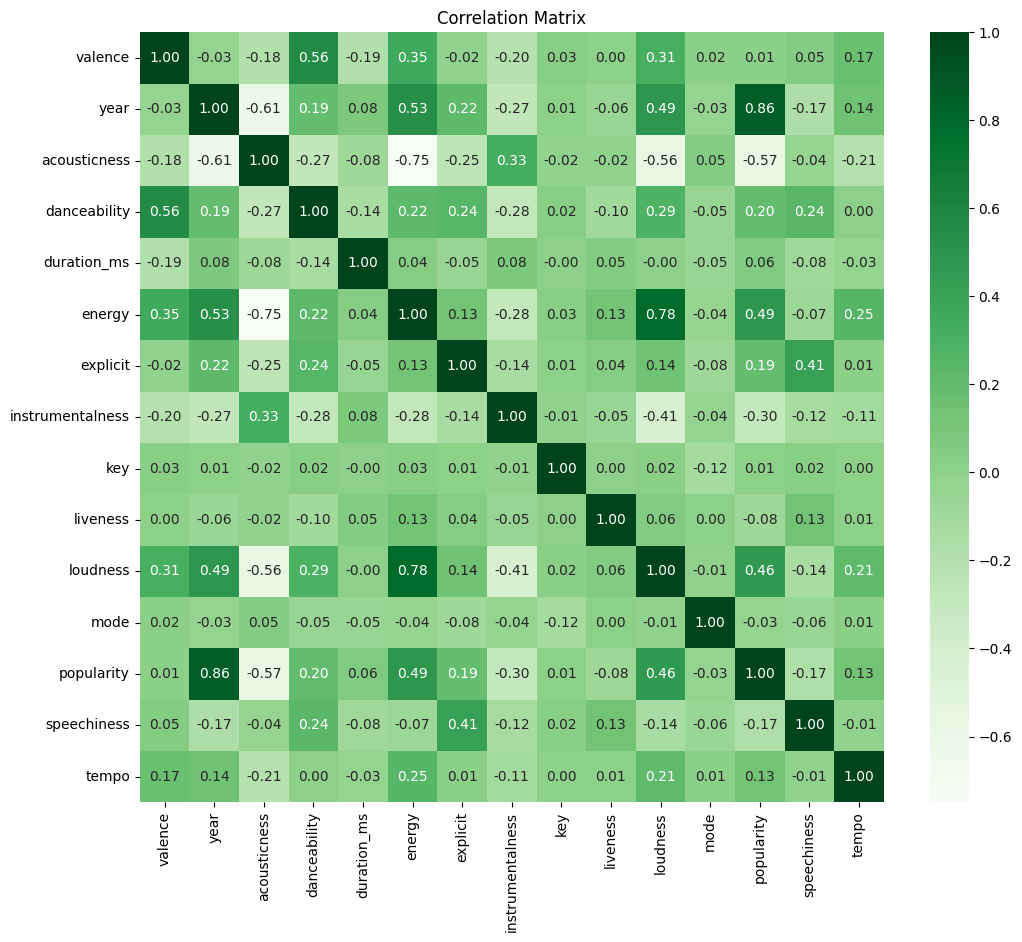

In [46]:
# veamos correlacion entre varialbes
correlation_matrix = df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='Greens')
plt.title('Correlation Matrix')
plt.show()


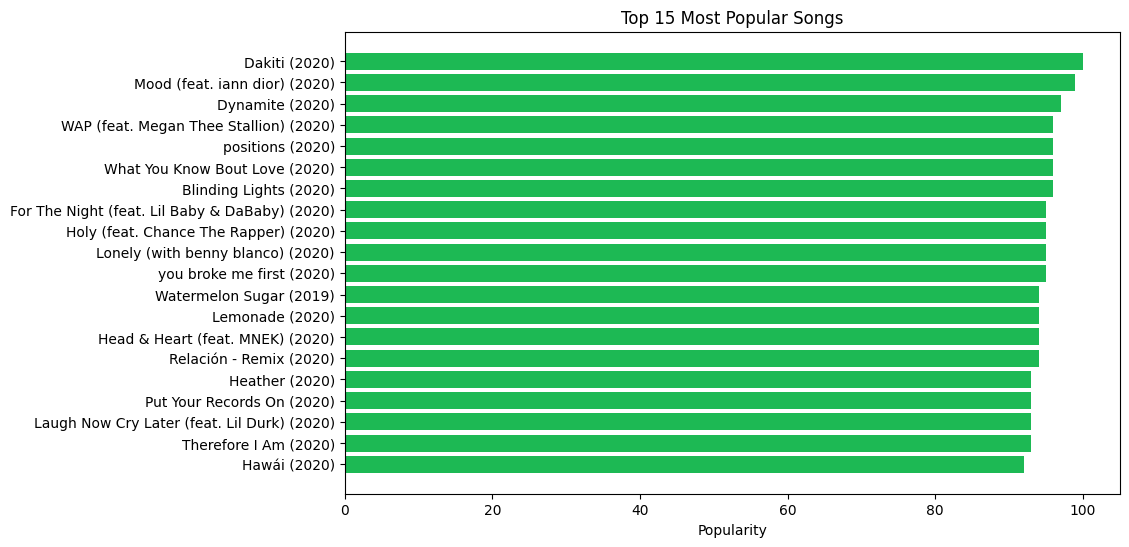

In [20]:
# hacer grafico de barras con las 15 canciones mas populares, agregar año junto al nombre


top_15 = df.sort_values(by="popularity", ascending=False).head(20)
plt.figure(figsize=(10,6))
plt.barh(top_15['name'] + " (" + top_15['year'].astype(str) + ")", top_15['popularity'], color='#1DB954')
plt.xlabel('Popularity')
plt.title('Top 15 Most Popular Songs')
plt.gca().invert_yaxis()
plt.show()


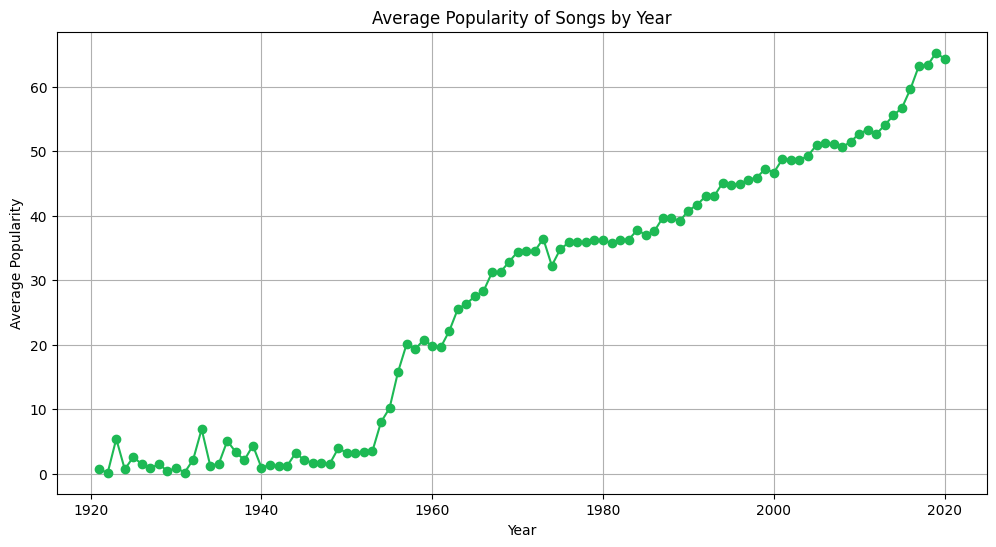

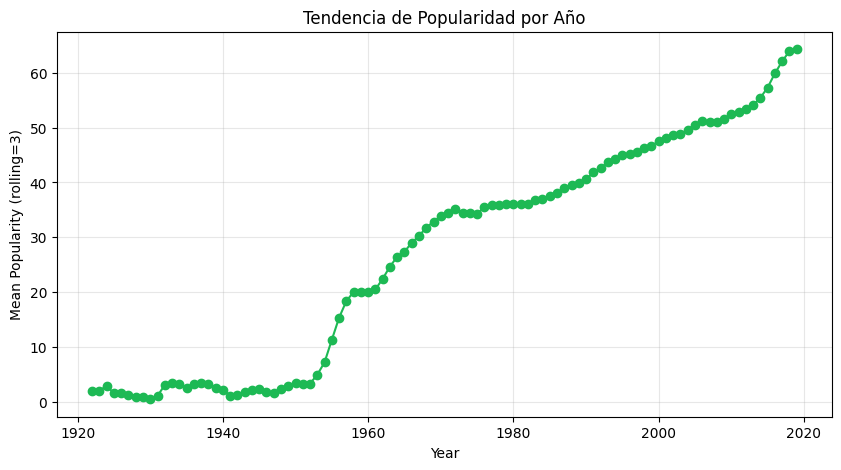

In [72]:
# gráfico de promedio de la popularidad por año
avg_popularity_per_year = df.groupby('year')['popularity'].mean().reset_index()
plt.figure(figsize=(12,6))
plt.plot(avg_popularity_per_year['year'], avg_popularity_per_year['popularity'], marker='o', color='#1DB954')
plt.xlabel('Year')
plt.ylabel('Average Popularity')
plt.title('Average Popularity of Songs by Year')
plt.grid()
plt.show()

# Serie temporal: popularidad media por año con smoothing (rolling)
ts = df.groupby('year')['popularity'].mean().rolling(3, center=True).mean()
plt.figure(figsize=(10,5))
plt.plot(ts.index, ts.values, marker='o', color='#1DB954')
plt.xlabel('Year')
plt.ylabel('Mean Popularity (rolling=3)')
plt.title('Tendencia de Popularidad por Año')
plt.grid(alpha=0.3)
plt.show()

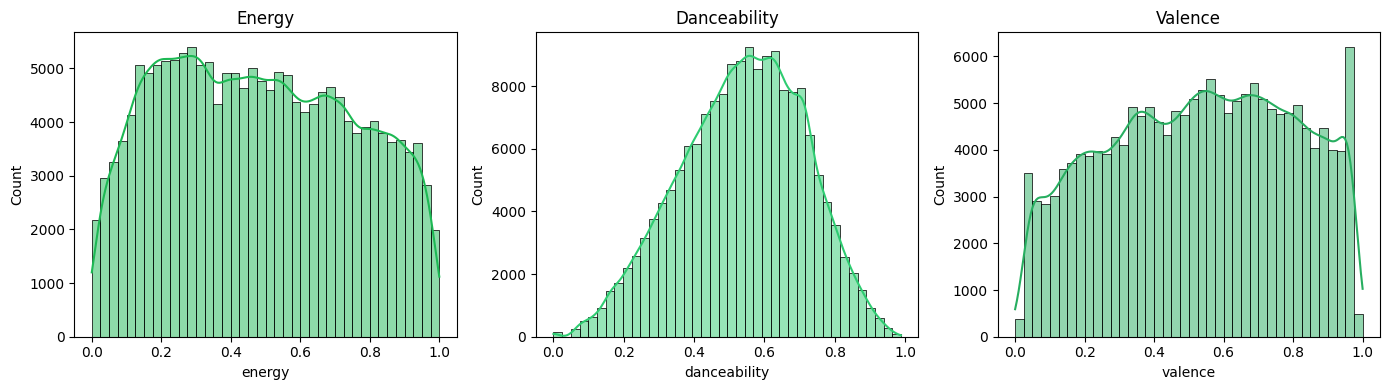

In [63]:
# Distribuciones univariadas: energy, danceability, valence
plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
sns.histplot(df['energy'].dropna(), kde=True, bins=40, color='#1DB954')
plt.title('Energy')

plt.subplot(1,3,2)
sns.histplot(df['danceability'].dropna(), kde=True, bins=40, color='#2ecc71')
plt.title('Danceability')

plt.subplot(1,3,3)
sns.histplot(df['valence'].dropna(), kde=True, bins=40, color='#27ae60')
plt.title('Valence')

plt.tight_layout()
plt.show()

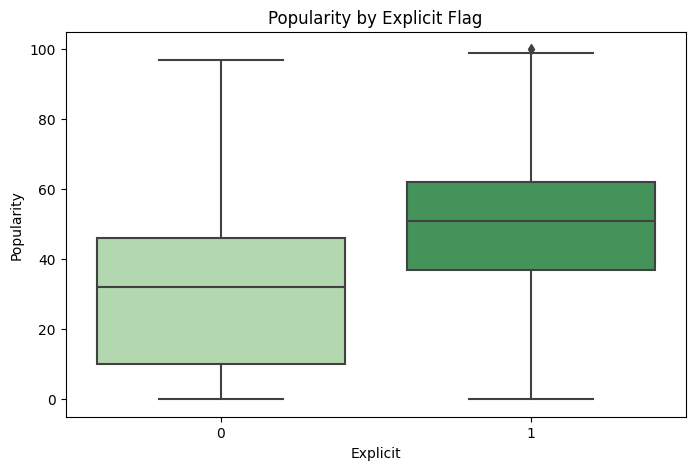

In [64]:
# Boxplot: popularidad por explicit (0/1)
plt.figure(figsize=(8,5))
sns.boxplot(x='explicit', y='popularity', data=df, palette='Greens')
plt.title('Popularity by Explicit Flag')
plt.xlabel('Explicit')
plt.ylabel('Popularity')
plt.show()

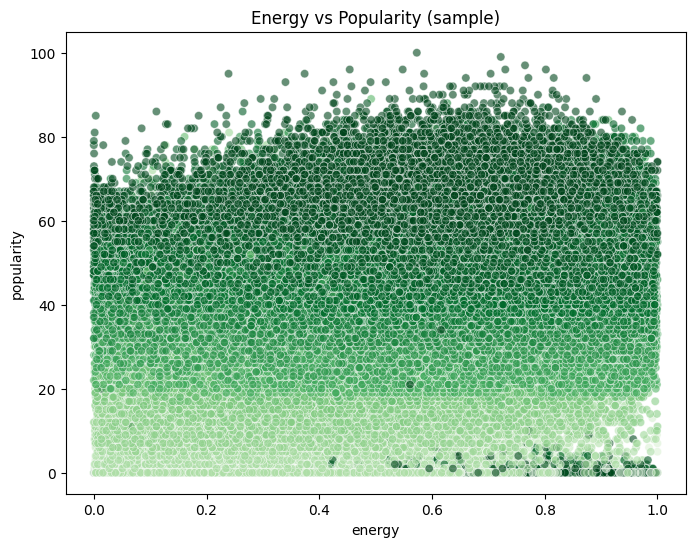

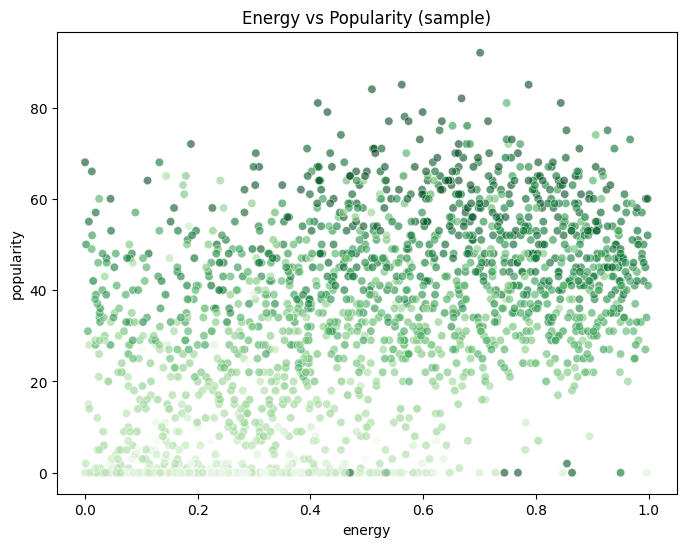

In [77]:
# Scatter: energy vs popularity (muestreo para evitar overplotting)
# n = min(2000, len(df))
# sample_df = df.sample(n=n, random_state=42)
plt.figure(figsize=(8,6))
sns.scatterplot(x='energy', y='popularity', data=df, hue='year' if 'year' in df.columns else None, palette='Greens', alpha=0.6, legend=False)
plt.title('Energy vs Popularity (sample)')
plt.show()

n = min(2000, len(df))
sample_df = df.sample(n=n, random_state=42)
plt.figure(figsize=(8,6))
sns.scatterplot(x='energy', y='popularity', data=sample_df, hue='year' if 'year' in df.columns else None, palette='Greens', alpha=0.6, legend=False)
plt.title('Energy vs Popularity (sample)')
plt.show()

In [78]:
# cantidad de distintos artistas en el dataset
num_artists = df['artists'].nunique()
print("Cantidad de distintos artistas en el dataset:", num_artists)

Cantidad de distintos artistas en el dataset: 34088


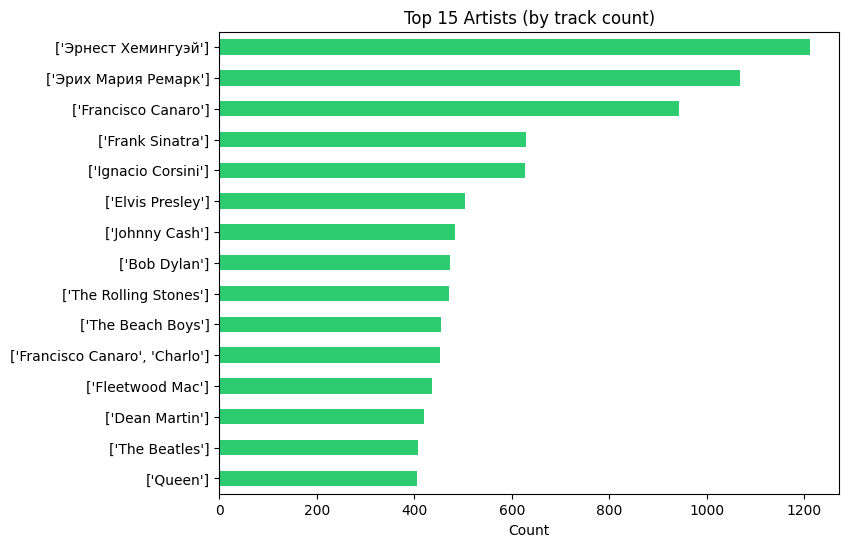

In [68]:
# Top artists (por cantidad de tracks) - barra horizontal
top_art = df['artists'].value_counts().head(15)
plt.figure(figsize=(8,6))
top_art.plot.barh(color='#2ecc71')
plt.gca().invert_yaxis()
plt.title('Top 15 Artists (by track count)')
plt.xlabel('Count')
plt.show()

Cantidad de canciones por año:


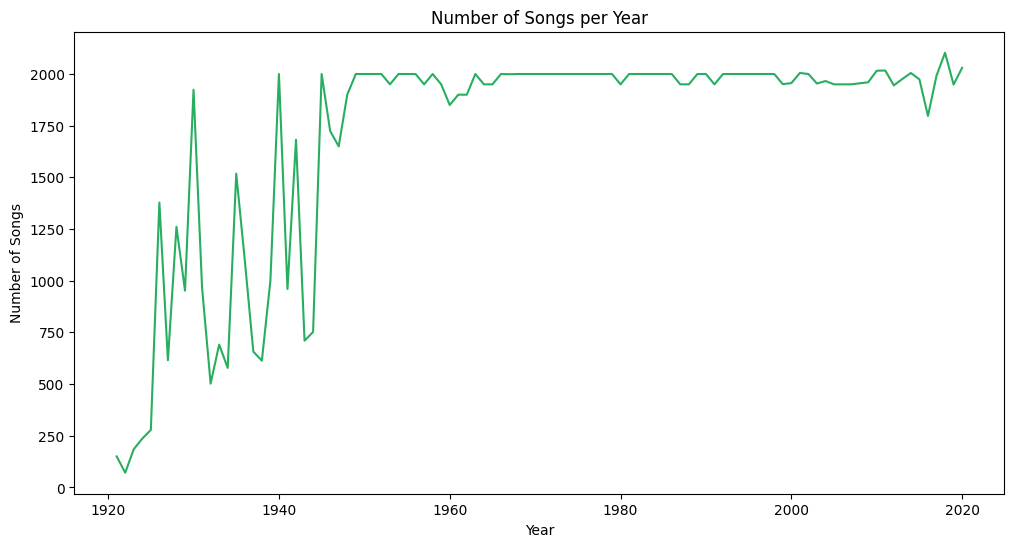

In [82]:
# cantidad de canciones por año grafico
songs_per_year = df['year'].value_counts().sort_index()
print("Cantidad de canciones por año:")
songs_per_year.plot(figsize=(12,6), color='#27ae60')
plt.title('Number of Songs per Year')
plt.xlabel('Year')
plt.ylabel('Number of Songs')
plt.show()


In [94]:
# agregar columna decada
df['decade'] = (df['year'] // 10) * 10

Agregue columna decada porque si graficaba todas las variables entre 0 y 1 como en el siguiente grafico por año quedaba un choclo

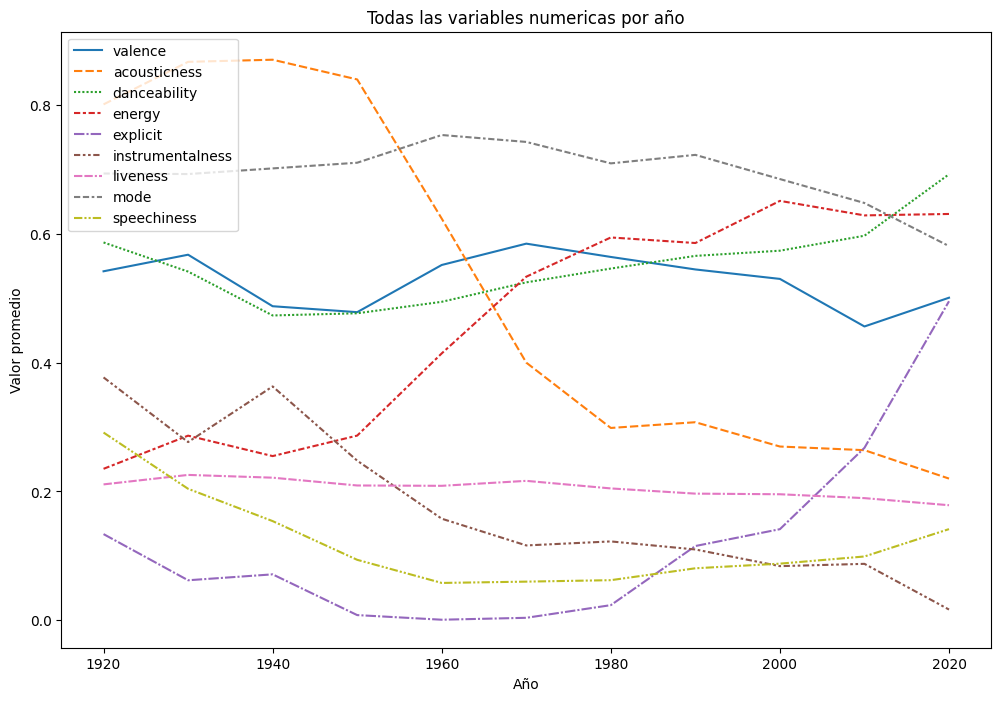

In [95]:
# todas las variables numericas por año
# variables
variables_numericas = df.select_dtypes(include=[np.number]).columns.tolist()
# sacar valores que no esten entre 0 y 1
variables_numericas = [var for var in variables_numericas if df[var].min() >= 0 and df[var].max() <= 1]

plt.figure(figsize=(12,8))
sns.lineplot(data=df.groupby('decade')[variables_numericas].mean())
plt.title('Todas las variables numericas por año')
plt.xlabel('Año')
plt.ylabel('Valor promedio')
plt.show()